In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.optimize as optm

import os
import sys
import time
from pathlib import Path
fun_lib_path = Path.home() / 'git/alexei_fun_lib' 
sys.path.append(str(fun_lib_path))

import collections
import functools

import optics_funs as of
import numerical_funs as nf
import matplotlib_funs as mpf
import LCT_funs as lctf
import general_funs as gef

import new_types as nt
import mutants

import finesse
import finesse.ligo
from finesse.cymath.homs import HGModes

import func_funs as ff
import graph_funs as grf
import finesse3_funs as f3f
import wolfram_funs as wlf

import networkx as nx
import pygraphviz as pgv
import pydot

from IPython.display import Image, SVG

In [3]:
code = """

laser L0 P=1

###############################################################################
###   PRC
###############################################################################
s sPRCin L0.p1 PRM.p1
m PRM
s lp1 PRM.p2 PR2.p1
bs PR2
s lp2 PR2.p2 PR3.p1
bs PR3
s lp3 PR3.p2 BS.p1
###############################################################################
###   BS
###############################################################################
bs BS
###############################################################################
###   Yarm
###############################################################################
# Distance from beam splitter to Y arm input mirror
s ly1 BS.p2 ITMY.p1
m ITMY
s LY ITMY.p2 ETMY.p1
m ETMY
###############################################################################
###   Xarm
###############################################################################
# Distance from beam splitter to X arm input mirror
s lx1 BS.p3 ITMX.p1
m ITMX
s LX ITMX.p2 ETMX.p1
m ETMX
###############################################################################
###   SRC
###############################################################################
s ls3 BS.p4 SR3.p1
bs SR3
s ls2 SR3.p2 SR2.p1
bs SR2
s ls1 SR2.p2 SRM.p1
m SRM
"""

In [4]:
kat2 = finesse.Model()
kat2.parse(code)

G0 = kat2.optical_network
G1 = grf.remove_sinks(grf.remove_orphans(G0))

In [5]:
remove_nodes = ['L0.p1.o', 'PR2.p3.i', 'PR2.p4.i', 'PR3.p3.i', 'PR3.p4.i', 'ETMY.p2.i', 'ETMX.p2.i', 'SR3.p3.i', 'SR3.p4.i', 'SR2.p3.i', 'SR2.p4.i', 'SRM.p2.i']
G2 = grf.remove_nodes_from(G1, remove_nodes)

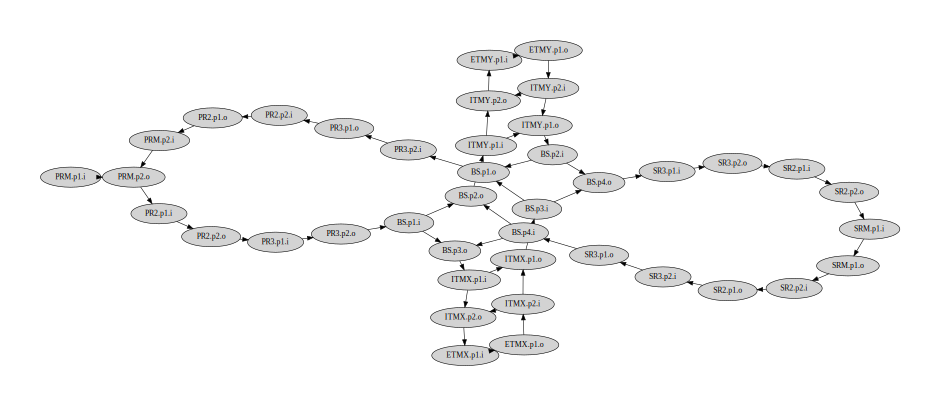

In [6]:
grf.drawing.graphviz_draw(network=G2, scale=np.array([1.2,-1]), maxiter=1000)

In [7]:
out0 = grf.drawing.graphviz_draw(network=G2, scale=np.array([1.2,-1]), maxiter=1000, ipython_display=False, format='pdf')
with open('DRMI_graph.pdf', 'wb') as f:
    f.write(out0)
    
!pdfcrop DRMI_graph.pdf DRMI_graph.pdf

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `DRMI_graph.pdf'.


In [8]:
GN = grf.copy_graph(G2)
GN = nx.relabel_nodes(GN, {n:str(i) for i,n in enumerate(GN)})

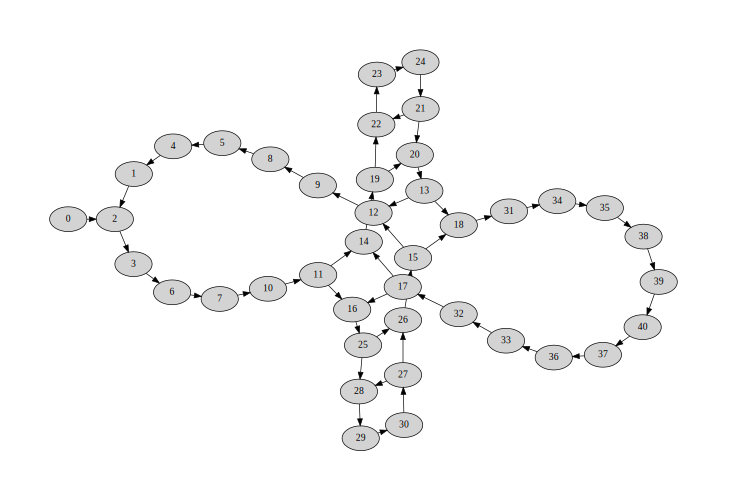

In [9]:
grf.drawing.graphviz_draw(network=GN, angle=0, scale=(0.72,-1))

In [10]:
out1 = grf.drawing.graphviz_draw(network=GN, angle=0, scale=(0.72,-1), ipython_display=False, format='pdf')
with open('DRMI_graph_num.pdf', 'wb') as f:
    f.write(out1)
    
!pdfcrop DRMI_graph_num.pdf DRMI_graph_num.pdf

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `DRMI_graph_num.pdf'.


In [7]:
GN = grf.copy_graph(G2)
mapping = {n:n+'\n'+(len(n)//2-1)*' '+str(i) for i,n in enumerate(G2.nodes)}
mapping = {n:f"{(len(n)//2-2)*' '}({i})\n{n}" for i,n in enumerate(G2.nodes)}
GN = nx.relabel_nodes(GN, mapping)

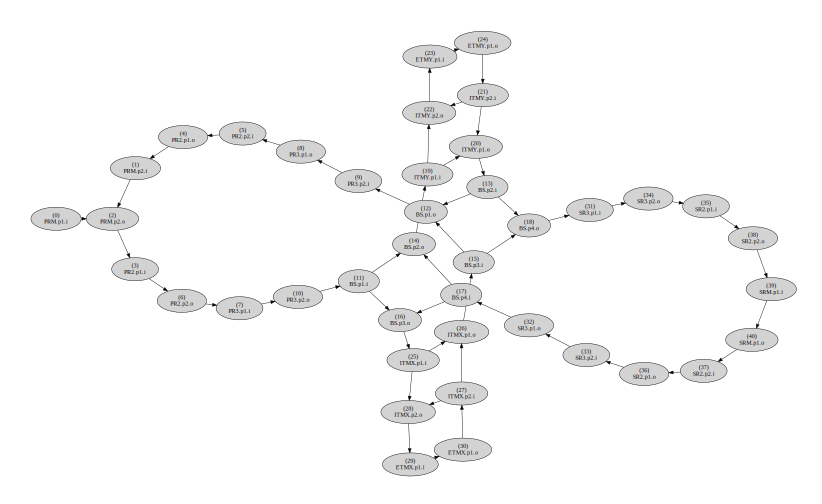

In [17]:
grf.drawing.graphviz_draw(network=GN, scale=[1.4,-1.8])

In [18]:
out1 = grf.drawing.graphviz_draw(network=GN, scale=[1.4,-1.8], ipython_display=False, format='pdf')
with open('DRMI_graph_num.pdf', 'wb') as f:
    f.write(out1)
    
!pdfcrop DRMI_graph_num.pdf DRMI_graph_num.pdf

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `DRMI_graph_num.pdf'.


In [20]:
!pdftk DRMI_graph_num.pdf cat 1-endwest output DRMI_graph_num_rot90.pdf

In [11]:
def get_pygraphviz_node_layout(A):
    """Extracts the node positions from a pygraphviz AGraph object
    in a networkx layout format.
    
    Note that pygraphviz only allows nodes to be strings. If the orignal
    networkx graph used non-string node identifiers (e.g. int) then the corresponding 
    nodes will be cast to strings in pygraphviz.
    
    Example
    ----------
    A = nx.drawing.nx_agraph.to_agraph(G)
    A.layout('neato')
    layout = get_pygraphviz_node_layout(A)
    nx.draw(G, pos=layout)
    """
    layout = {}
    for node in A.nodes():
        pos_str = node.attr['pos']
        pos = [float(p) for p in pos_str.split(',')]
        layout[node.name] = pos
    return layout

def networkx_pygraphviz_layout(G, layout='neato'):
    A = nx.drawing.nx_agraph.to_agraph(G)
    A.layout(layout)
    layout = get_pygraphviz_node_layout(A)
    